In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

In [126]:
# global variables

# Time window for the event
event_time = pd.to_datetime("2011-03-11 05:46:00")
#start_time = "2011-03-11 05:00:00"
#end_time = "2011-03-11 08:00:00"

# station ID's -> to be filled in
gs1 = 'g103'
gs2 = 'mizu'
gs3 = 'g205'
gs_id = [gs1, gs2, gs3]

# epicenter
epicentre = ((38.321944, 142.368889)) # latitude, longitude -> to be adapted CRS????
epi_lat, epi_lon = epicentre


# Define a sliding window size 
window_size = '15min'  # 10 minutes

In [127]:
# output dir
output_dir = '/workspaces/tsunami-vtec-waves/wave_propagation_speed/'

# Outline

This document is based on df_filtered.csv derived from residuals_plus_bandfilter-3.ipynb\
The csv contains only satellite data of satellites in contact with groundstations during the event window.\
The csv already contains the residuals upon which this file builds up

1. Import filtered data
2. analyse timeseries with curtosis for siginificant peaks ( > 3) using a sliding window
3. norm data with sdv and mean
4. define threshold for when wave arrives at station e.g. 50
5. If threshold is passed -> wave is there, get coordinates and time
6. use horizontal distance and calculate distance to epicenter
7. v = ds/dt




In [128]:
# Load filtered data and set date as index
df = pd.read_csv('df_filtered.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
df.set_index('datetime', inplace=True)

# sort by date
df_filtered = df.sort_index()

#filter between start and end time
#df = df.loc[start_time:end_time]

# analyse data columns
df.columns

Index(['year', 'month', 'day', 'hour', 'min', 'sec', 'recno', 'kindat',
       'kinst', 'ut1_unix', 'ut2_unix', 'pierce_alt', 'gps_site', 'sat_id',
       'gnss_type', 'gdlatr', 'gdlonr', 'los_tec', 'dlos_tec', 'tec', 'azm',
       'elm', 'gdlat', 'glon', 'rec_bias', 'drec_bias', 'residuals',
       'band_filtered'],
      dtype='object')

In [129]:
# build dictionary of groundstation and list of satellites in contact with gs at event_time

def get_satellites_in_contact(df, station_id, event_time):
    """
    Check which satellites were in contact with groundstationd during event time
    
    In: Dataframe, ground station id, eventtime
    Out: List of satellite ids which were in contact during event time

    """
    df_filtered = df[(df['gps_site'] == station_id) & (df.index == event_time)]
    satellites_in_contact = df_filtered['sat_id'].unique()

    return satellites_in_contact.tolist()

sat_data = {}
for i in gs_id:
    sat_data[i] = get_satellites_in_contact(df,i,event_time)

In [130]:
#count amount of satellites in contact with each groundstation
amount = 0
for i in sat_data.values():
    amount += len(i)
print(amount)

23


## Kurtosis (Wölbung) analysis
$\to$ from https://de.wikipedia.org/wiki/W%C3%B6lbung_(Statistik)


Die *Wölbung* (w), Kyrtosis, Kurtosis oder auch Kurtose (griechisch κύρτωσις kýrtōsis „Krümmen“, „Wölben“) ist eine Maßzahl für die Steilheit bzw. „Spitzigkeit“ einer (eingipfligen) Wahrscheinlichkeitsfunktion, statistischen Dichtefunktion oder Häufigkeitsverteilung.[1] Die Wölbung ist das standardisierte (zentrale) Moment 4. Ordnung. \
Die Wölbung kann nur nicht-negative Werte annehmen.\
- w < 3 $\to$ deutet darauf, dass die standardisierten Beobachtungen $\displaystyle z_{i}$ nahe dem Mittelwert konzentriert sind, d. h. die Verteilung ist flachgipflig
- w > 3  ist die Verteilung im Vergleich zu einer Normalverteilung spitzgipflig $\to$ indiz für peak


![Flachgipflig.svg.png](attachment:Flachgipflig.svg.png) ![Steilgipflig.svg.png](attachment:Steilgipflig.svg.png)

### Excess kurtosis
Der **Exzess** gibt die Differenz der Wölbung der betrachteten Funktion zur Wölbung der Dichtefunktion einer normalverteilten Zufallsgröße an.[1]\
Um das Ausmaß der Wölbung besser einschätzen zu können, wird sie mit der Wölbung einer Normalverteilung verglichen, für die $\beta_2 = 3$ gilt. 

Arten von Exzess:

- $\displaystyle \mathrm {Exzess} =0$: normalgipflig oder mesokurtisch. Die Normalverteilung hat die Kurtosis $\displaystyle \beta _{2}=3$ und entsprechend den Exzess .
- $\displaystyle \mathrm {Exzess} >0$: steilgipflig, supergaußförmig oder leptokurtisch. Es handelt sich hierbei um im Vergleich zur Normalverteilung spitzere Verteilungen, d. h. Verteilungen mit starken Peaks.
- $\displaystyle \mathrm {Exzess} <0$: flachgipflig, subgaußförmig oder platykurtisch. Man spricht von einer im Vergleich zur Normalverteilung abgeflachten Verteilung.


## Deriving Kurtosis
Per sat per groundstation over the rolling window:
- calculate kurtosis $\to$ using scipy (deactivating Fisher $\to$ not calculating excess kurtosis)
- normalize kurtosis
- std of kurtosis

In [131]:
# Function to calculate rolling kurtosis
# calculate kurtosis with scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)

def calculate_kurtosis(group):
    return group['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)

In [132]:
def kurtosis_wrapper(x):
    return kurtosis(x, fisher=False, bias=False, nan_policy='omit')

In [133]:
def first_peak(df):
    #reindex df from date time to integer to ensure rows are distinguishable (same time stamp several times)
    df = df.reset_index()

    # assess first occurence of df['peak'] == True, idxmax works because True > False
    first_peak_idx = df['peak'].idxmax()

    #assess that first_peak_idx != Nan
    counter = 0
    if pd.notna(first_peak_idx):
        # set the column df['first_peak'] = True
        df['first_peak'] = False
        df.loc[first_peak_idx, 'first_peak'] = True
        counter += 1

    # set datetime as index again
    df.set_index('datetime', inplace=True)

    #assert that only one peak detected (one peak per satellite)
    assert counter <= 1, "More than one peak detected"
    return df, counter


In [134]:
# alternative for first peak detection

def first_peak_detection(df):
    #initalize counter
    counter = 0

    # Reindex df from datetime to integer to handle any duplicate timestamps
    df = df.reset_index(drop=False)
    
    # Find the first peak after the event_time
    mask = (df['peak'] == True) & (df['datetime'] > pd.to_datetime(event_time))
    
    if not mask.any():
        print('No peak detected after the event')
        return df, counter
    
    
    # get row where first peak after the event appears
    first_peak_idx = df[(df['peak'] == True) & (df['datetime'] > event_time)].index[0]
    if pd.notna(first_peak_idx):
        # set the column df['first_peak'] = True
        df['first_peak'] = False
        df.loc[first_peak_idx, 'first_peak'] = True
        counter += 1

    # set datetime as index again
    df = df.set_index('datetime')
    print(df[df['first_peak'] == True])

    #assert that only one peak detected (one peak per satellite)
    assert counter <= 1, "More than one peak detected"
    

    return df,counter

In [135]:
# iterate through satellite per groundstaiton and calculate rolling kurtosis
results = []

number_of_first_peaks = 0
for station in gs_id:
    for sat_id in sat_data[station]:
        df_sat = df[(df['gps_site'] == station) & (df['sat_id'] == sat_id)]
        #df_sat.loc[(df_sat['gps_site'] == station) & (df_sat['sat_id'] == sat_id), 'kurtosis'] = df_sat.loc[(df_sat['gps_site'] == station) & (df_sat['sat_id'] == sat_id), 'residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
        df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)

        # normalize kurtosis
        df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()

        # add rolling standard deviation of normalized kurtosis
        df_sat['kurtosis_norm_std'] = df_sat['kurtosis_norm'].rolling(window=window_size).std()

        # detect peaks after event time: Peak if kurtosis_norm > 2*std and time > event_time
        df_sat['peak'] = (df_sat['kurtosis_norm'] > 3*df_sat['kurtosis_norm_std']) & (df_sat.index > event_time)

        # max peak detection: Max if over whole data set highest kurtosis_norm and time > event_time
        df_sat['max_peak'] = (df_sat['kurtosis_norm'] == df_sat['kurtosis_norm'].max()) & (df_sat.index > event_time) 
        print(f"length of df_sat after max: {len(df_sat)}")

        # first peak detection
        df_sat, counter = first_peak_detection(df_sat)
        print(f"length of df_sat after first: {len(df_sat)}")
        # count number of first peaks
        number_of_first_peaks += counter

        # store results
        results.append(df_sat)
kurtosis_df = pd.concat(results)



/tmp/ipykernel_2314/4063146816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
/tmp/ipykernel_2314/4063146816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()
/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

length of df_sat after max: 262
No peak detected after the event
length of df_sat after first: 262
length of df_sat after max: 321
                     year  month  day  hour  min  sec  recno  kindat  kinst  \
datetime                                                                      
2011-03-11 06:00:30  2011      3   11     6    0   30    721    3505   8000   

                         ut1_unix  ...  rec_bias  drec_bias residuals  \
datetime                           ...                                  
2011-03-11 06:00:30  1.299823e+09  ... -215216.5   1.301743  0.760444   

                     band_filtered   kurtosis  kurtosis_norm  \
datetime                                                       
2011-03-11 06:00:30       0.416247  17.820756      12.082117   

                     kurtosis_norm_std  peak  max_peak  first_peak  
datetime                                                            
2011-03-11 06:00:30           2.335261  True      True        True  

[1 rows x 

/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm_std'] = df_sat['kurtosis_norm'].rolling(window=window_size).std()
/tmp/ipykernel_2314/4063146816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['peak'] = (df_sat['kurtosis_norm'] > 3*df_sat['kurtosis_norm_std']) & (df_sat.index > event_time)
/tmp/ipykernel_2314/4063146816.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

                     year  month  day  hour  min  sec  recno  kindat  kinst  \
datetime                                                                      
2011-03-11 05:58:30  2011      3   11     5   58   30    717    3505   8000   

                         ut1_unix  ...     rec_bias  drec_bias residuals  \
datetime                           ...                                     
2011-03-11 05:58:30  1.299823e+09  ... -215228.0625   1.305933 -0.168827   

                     band_filtered  kurtosis  kurtosis_norm  \
datetime                                                      
2011-03-11 05:58:30      -0.154718  5.677353       3.496994   

                     kurtosis_norm_std  peak  max_peak  first_peak  
datetime                                                            
2011-03-11 05:58:30           1.053913  True     False        True  

[1 rows x 34 columns]
length of df_sat after first: 288
length of df_sat after max: 321
                     year  month  day  hour  mi

/tmp/ipykernel_2314/4063146816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
/tmp/ipykernel_2314/4063146816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()
/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

                     year  month  day  hour  min  sec  recno  kindat  kinst  \
datetime                                                                      
2011-03-11 06:02:00  2011      3   11     6    2    0    724    3505   8000   

                         ut1_unix  ...       rec_bias  drec_bias residuals  \
datetime                           ...                                       
2011-03-11 06:02:00  1.299823e+09  ... -215212.078125   1.301885 -0.124538   

                     band_filtered  kurtosis  kurtosis_norm  \
datetime                                                      
2011-03-11 06:02:00      -0.123409  4.920754       2.235758   

                     kurtosis_norm_std  peak  max_peak  first_peak  
datetime                                                            
2011-03-11 06:02:00           0.707737  True     False        True  

[1 rows x 34 columns]
length of df_sat after first: 321
length of df_sat after max: 321
                     year  month  day  ho

/tmp/ipykernel_2314/4063146816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
/tmp/ipykernel_2314/4063146816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()
/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

length of df_sat after max: 93
                     year  month  day  hour  min  sec  recno  kindat  kinst  \
datetime                                                                      
2011-03-11 05:56:00  2011      3   11     5   56    0    712    3505   8000   

                         ut1_unix  ...      rec_bias  drec_bias residuals  \
datetime                           ...                                      
2011-03-11 05:56:00  1.299823e+09  ... -91262.242188   1.301536  0.157086   

                     band_filtered  kurtosis  kurtosis_norm  \
datetime                                                      
2011-03-11 05:56:00       0.501508  6.073692       2.683069   

                     kurtosis_norm_std  peak  max_peak  first_peak  
datetime                                                            
2011-03-11 05:56:00           0.719969  True     False        True  

[1 rows x 34 columns]
length of df_sat after first: 93
length of df_sat after max: 93
               

/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm_std'] = df_sat['kurtosis_norm'].rolling(window=window_size).std()
/tmp/ipykernel_2314/4063146816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['peak'] = (df_sat['kurtosis_norm'] > 3*df_sat['kurtosis_norm_std']) & (df_sat.index > event_time)
/tmp/ipykernel_2314/4063146816.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

                     year  month  day  hour  min  sec  recno  kindat  kinst  \
datetime                                                                      
2011-03-11 05:58:00  2011      3   11     5   58    0    716    3505   8000   

                         ut1_unix  ...      rec_bias  drec_bias residuals  \
datetime                           ...                                      
2011-03-11 05:58:00  1.299823e+09  ... -91253.929688   1.306125  0.085981   

                     band_filtered  kurtosis  kurtosis_norm  \
datetime                                                      
2011-03-11 05:58:00       0.065042  7.866913        5.34585   

                     kurtosis_norm_std  peak  max_peak  first_peak  
datetime                                                            
2011-03-11 05:58:00           1.218672  True      True        True  

[1 rows x 34 columns]
length of df_sat after first: 93
length of df_sat after max: 93
No peak detected after the event
length of df_

/tmp/ipykernel_2314/4063146816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
/tmp/ipykernel_2314/4063146816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()
/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

length of df_sat after max: 139
                     year  month  day  hour  min  sec  recno  kindat  kinst  \
datetime                                                                      
2011-03-11 06:00:00  2011      3   11     6    0    0    720    3505   8000   

                         ut1_unix  ...      rec_bias  drec_bias residuals  \
datetime                           ...                                      
2011-03-11 06:00:00  1.299823e+09  ... -91275.929688    1.32178 -0.284441   

                     band_filtered kurtosis  kurtosis_norm  kurtosis_norm_std  \
datetime                                                                        
2011-03-11 06:00:00      -0.447409  3.66927       1.188645           0.374122   

                     peak  max_peak  first_peak  
datetime                                         
2011-03-11 06:00:00  True     False        True  

[1 rows x 34 columns]
length of df_sat after first: 139
length of df_sat after max: 139
               

/tmp/ipykernel_2314/4063146816.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm_std'] = df_sat['kurtosis_norm'].rolling(window=window_size).std()
/tmp/ipykernel_2314/4063146816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['peak'] = (df_sat['kurtosis_norm'] > 3*df_sat['kurtosis_norm_std']) & (df_sat.index > event_time)
/tmp/ipykernel_2314/4063146816.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [136]:
# assess valitiy of first peaks
amount = 0
for i in sat_data.values():
    amount += len(i)
print(f"amount of first peaks: {number_of_first_peaks}")
print(f"amount of max peaks: {kurtosis_df['max_peak'].sum()}")
print(f"amount of satellites in contact: {amount}")


amount of first peaks: 18
amount of max peaks: 15
amount of satellites in contact: 23


In [137]:
print(len(kurtosis_df[kurtosis_df['peak'] == True]))

51


## Plot to check results

In [138]:
def plot_kurtosis(column_name:str, kurtosis_df, station:str, sat_data, safe_fig = False):
    """
    Plot kurtosis for each satellite per station indicated, 
    highlighting the event time and each satellite in different color.

    In: column_name:str, kurtosis_df:df, station:str, sat_data
    Out: plot of kurtosis for each satellite
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df_sat = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df_sat.plot(y=column_name, ax=ax, label=f'{station}, sat {sat_id}')

    # plot event time
    plt.axvline(x=event_time, color='r', linestyle='--')
    # beschriftung etc
    plt.title(f'{column_name} of residuals of ground station "{station}" over rolling window of {window_size}')
    plt.ylabel('Kurtosis')
    plt.legend()
    plt.show()

    #save to folder wave propagation speed 
    if safe_fig == True:
        fig.savefig(f"{output_dir}/kurtosis_{station}_{column_name}.png")

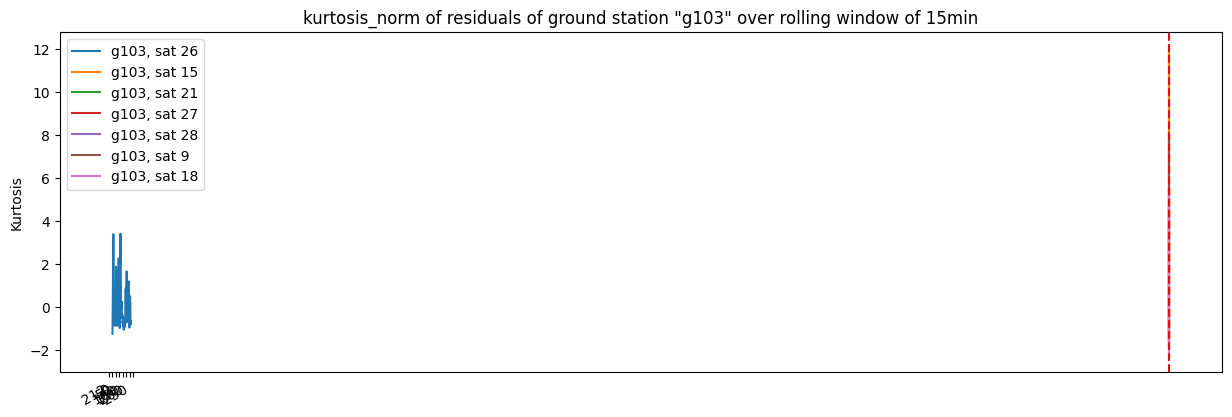

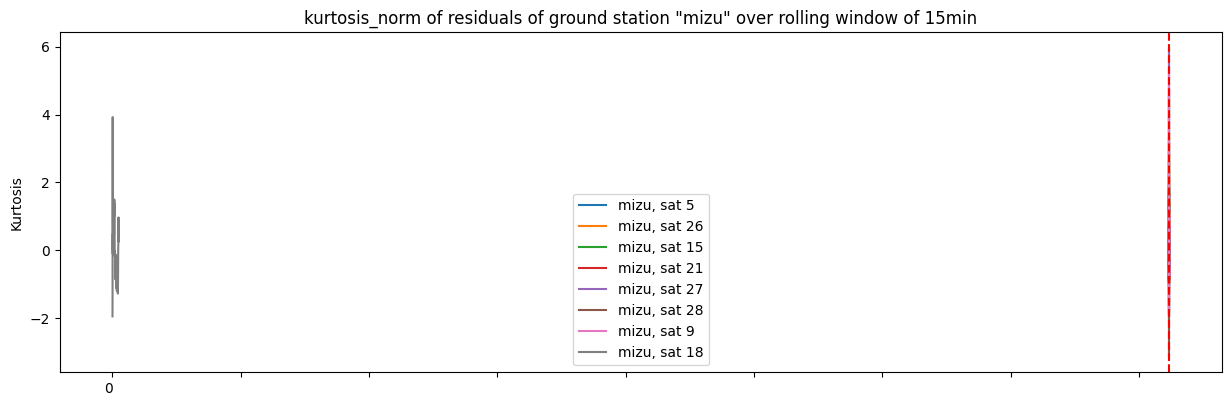

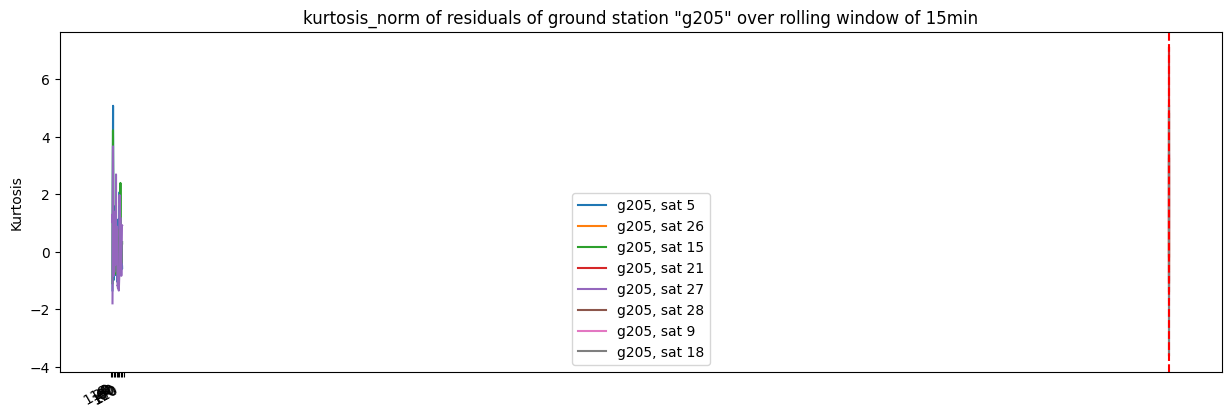

In [139]:
# plot for all stations
for station in gs_id:
    plot_kurtosis('kurtosis_norm', kurtosis_df, station, sat_data)

## Peak detection

- Peak detection per satellite per groundstation
- Peak if threshold is $3 \sigma$ $\to$ why?

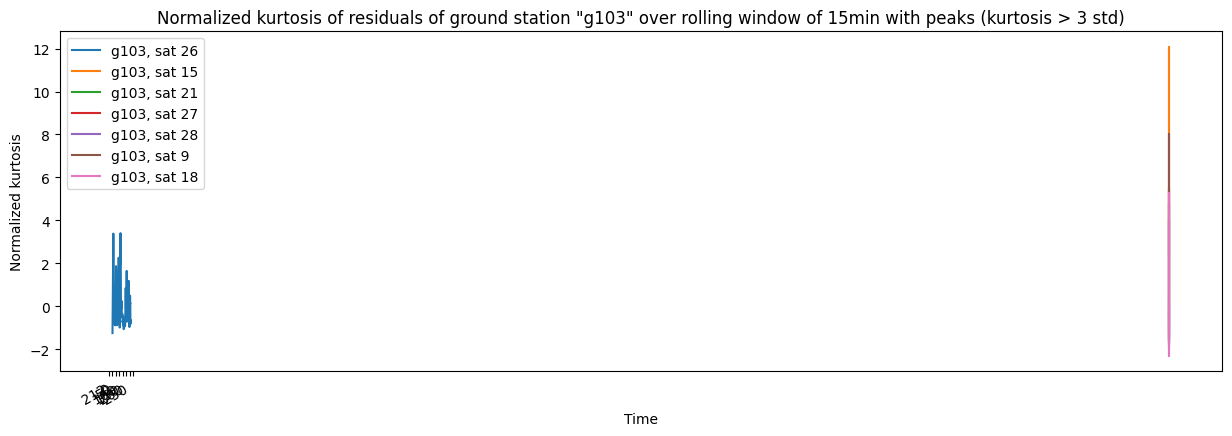

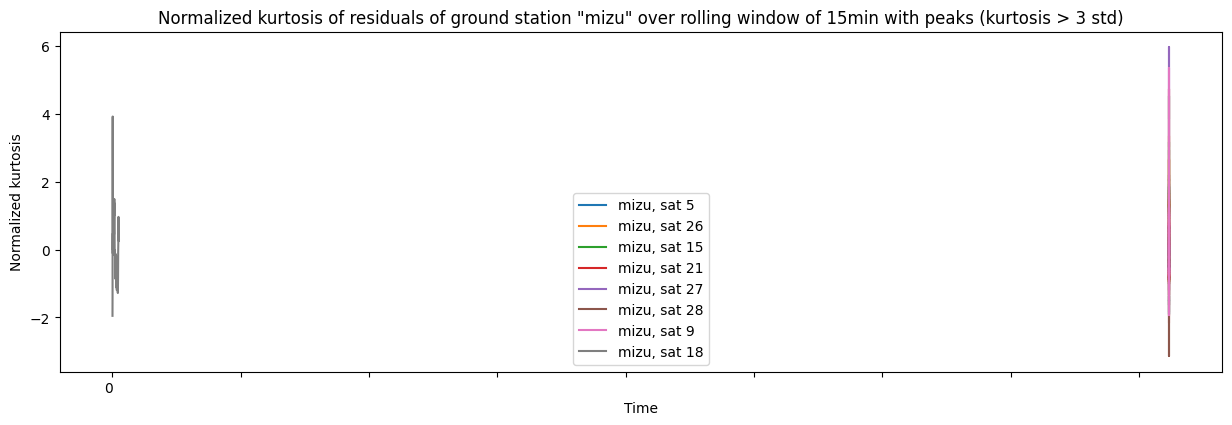

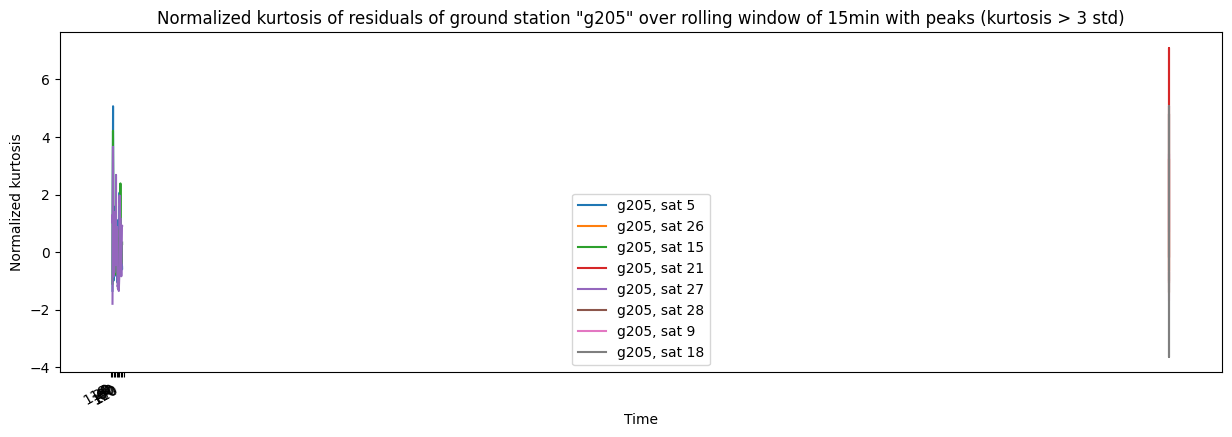

In [ ]:
# peak detection

# peak if kurtosis is above 3 std
#kurtosis_df['peak'] = kurtosis_df['kurtosis_norm'] > 3 * kurtosis_df['kurtosis_norm_std']

# plot peaks
for station in gs_id:
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df.plot(y='kurtosis_norm', ax=ax, label=f'{station}, sat {sat_id}')
        # plot all peaks
        #df[df['peak']].plot(y='kurtosis_norm', ax=ax, style='o', label=f'{station}, sat {sat_id} peak', color= 'b')
        #plot max peaks
        #df[df['max_peak']].plot(y='kurtosis_norm', ax=ax, style='o', label=f'{station}, sat {sat_id} max peak', color='g')
        #plot first peaks
        #df[df['first_peak']].plot(y='kurtosis_norm', ax=ax, style='o', label=f'{station}, sat {sat_id} first peak', color='r')
    plt.axvline(x=event_time, color='r', linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized kurtosis")
    plt.title(f'Normalized kurtosis of residuals of ground station "{station}" over rolling window of {window_size} with peaks (kurtosis > 3 std)')
    plt.show()
    #save to folder wave propagation speed 
    #fig.savefig(f"{output_dir}/kurtosis_n_{station}_peak.png")


In [ ]:
# plot sat 15 for G103
df_sat = kurtosis_df[(kurtosis_df['gps_site'] == 'g103') & (kurtosis_df['sat_id'] == 15)]
fig, ax = plt.subplots(figsize=(15, 5))
df_sat.plot(y='kurtosis_norm', ax=ax, label='g103, sat15')
#plot max peak
df_sat[df_sat['max_peak']].plot(y='kurtosis_norm', ax=ax, style='o', label='g103, sat15 max peak', color='g')
plt.axvline(x=event_time, color='r', linestyle='--')
plt.title('Normalized kurtosis of residuals of ground station "g103" over rolling window of 15 minutes')
plt.ylabel('Kurtosis')
plt.legend()
plt.show()

print(df_sat[df_sat['max_peak']== True])


## Speed calculation

In [ ]:
# filter for kurtosis peaks after event time
kurtosis_peaks = kurtosis_df[(kurtosis_df['peak']) & (kurtosis_df.index > event_time)]

In [ ]:
# calculate time difference between event time and peak time
kurtosis_peaks['time_diff'] = (kurtosis_peaks.index - event_time).total_seconds()

kurtosis_peaks.head()

In [ ]:
# calculate distance between ground station and epicenter
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# calculate distance between ground station and epicenter
kurtosis_peaks['distance'] = haversine(epi_lat, epi_lon, kurtosis_peaks['gdlat'], kurtosis_peaks['glon']) #km


In [ ]:
# calculate wave propagation speed
kurtosis_peaks['wave_speed'] = kurtosis_peaks['distance'] / kurtosis_peaks['time_diff'] #km/s
print(kurtosis_peaks['wave_speed'])

# to do: 
- how to make sure that peak after event time is not within range of normal spread\
-> filter for max peak before event and max peak after event
- calculate velocity only for peaks after event which are bigger than peaks before event

Input:
- Plot data before calculating speed to know if it is the right peak
- read some more papers on wave speed propagation -> which peak first or highest?
- rolling window size can be tuned

Do: calculate std before event and then check if peak > 2-3 std after event

# Plotting of residuals per satellite per groundstation

In [ ]:
# plot residuals for each satellite in contact with groundstation
def plot_tec(df, sat_id, station_id, event_time):
    #filter for satellites in df
    df_filtered = df[(df['gps_site'] == station_id) & (df['sat_id'] == sat_id)]
    df_filtered.plot(y = 'residuals', title = f'Residuals data for sat "{sat_id}" in contact with {station_id} at {event_time}')
    # indicate event
    plt.axvline(x=event_time, color='r', linestyle='--',label="Event Marker")
    plt.show()
for i in gs_id:
    for sat_id in sat_data[i]:
        print(sat_id)
        print(df.loc[df['sat_id'] == sat_id, 'sat_id'])
        plot_tec(df, sat_id, i, event_time)
    

# Old

In [ ]:
# plot kurtosis per groundstation highlighting the event time and each satellite in different color
for station in gs_id:
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df_sat = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df_sat.plot(y='kurtosis', ax=ax, label=f'{station}, sat {sat_id}')
    plt.axvline(x=event_time, color='r', linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Kurtosis")
    plt.title(f'Kurtosis of residuals of ground station "{station}" over rolling window of {window_size}')
    plt.show()
    #save to folder wave propagation speed 
    fig.savefig(f"{output_dir}/kurtosis_{station}.png")


In [ ]:
# plot kurtosis per groundstation highlighting the event time and each satellite in different color
for station in gs_id:
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df_sat = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df_sat.plot(y='kurtosis_norm', ax=ax, label=f'{station}, sat {sat_id}')
    plt.axvline(x=event_time, color='r', linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized kurtosis")
    plt.title(f'Normalized kurtosis of residuals of ground station "{station}" over rolling window of {window_size}')
    plt.show()
    #save to folder wave propagation speed 
    fig.savefig(f"{output_dir}/kurtosis_n_{station}.png")
